# Data Preprocessing for RAG

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import gc 
import torch
from transformers import AutoTokenizer
from scipy.stats import describe
from transformers import DistilBertTokenizer, DistilBertModel

In [2]:
# Uploading datasets

file_path = '/kaggle/input/foodcom-recipes-and-reviews/'
pd.set_option('display.max_columns', None)
recipes_df = pd.read_csv(file_path + 'recipes.csv')
reviews_df = pd.read_csv(file_path + 'reviews.csv')

#recipes_df.head()

In [3]:
#Dataset overview
recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


We can already eliminate some columns which are not relevant for our task.

In [5]:
recipes_selected = recipes_df.drop(columns=['DatePublished', 'Images', 'AuthorName', 'RecipeYield'])

## Missing Values

First, we examine the number of missing values across features.

In [6]:
recipes_selected.isna().sum()

RecipeId                           0
Name                               0
AuthorId                           0
CookTime                       82545
PrepTime                           0
TotalTime                          0
Description                        5
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeInstructions                 0
dtype: int64

We first drop rows with NaNs in Keywords since this is the basis for filtering non-plant-baced recipes.

In [7]:
# Drop NaNs in Keywords

recipes_selected = recipes_selected.dropna(subset=['Keywords'])

To be able to filter rows based on values, we need to clean and convert some columns from dictionaries into lists.

In [8]:
# Cleaning and converting dictionary columns

def clean_wrappers(value):
    if isinstance(value, str) and value.startswith('c('):
        value = value[2:-1]  
        return [item.strip().strip('"') for item in value.split(",")]  
    elif isinstance(value, str) and value.startswith('PT'):
        return value[2:].strip()  
    else:
        return value 

columns_to_clean = ["Keywords",	'CookTime', 'PrepTime', 'TotalTime', "RecipeIngredientQuantities", "RecipeIngredientParts", "RecipeInstructions"]
for col in columns_to_clean:
    recipes_selected[col] = recipes_selected[col].apply(clean_wrappers)

recipes_selected.head()

,RecipeId,Name,AuthorId,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,24H,45M,24H45M,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","[4, 1/4, 1, 1]","[blueberries, granulated sugar, vanilla yogurt...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,"[Toss 2 cups berries with sugar., Let stand fo..."
1,39,Biryani,1567,25M,4H,4H25M,Make and share this Biryani recipe from Food.com.,Chicken Breast,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[1, 4, 2, 2, 8, 1/4, 8, 1/2, 1, 1, 1/4, 1/4, 1...","[saffron, milk, hot green chili peppers, onion...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,[Soak saffron in warm milk for 5 minutes and p...
2,40,Best Lemonade,1566,5M,30M,35M,This is from one of my first Good House Keepi...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","[1 1/2, 1, NA, 1 1/2, NA, 3/4]","[sugar, lemons, rind of, lemon, zest of, fresh...",4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,"[Into a 1 quart Jar with tight fitting lid, pu..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,20M,24H,24H20M,This dish is best prepared a day in advance to...,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,...","[12, 1, 2, 1, 10, 1, 3, 2, 2, 2, 1, 2, 1/2, 1/...","[extra firm tofu, eggplant, zucchini, mushroom...",4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,"[Drain the tofu, carefully squeezing out exces..."
4,42,Cabbage Soup,1538,30M,20M,50M,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,..."


## Filtering

We print out all unique keywords to identify potentially non-plant-based ones.

In [9]:
recipes_selected['Keywords'].explode().unique()

array(['Dessert', 'Low Protein', 'Low Cholesterol', 'Healthy',
       'Free Of...', 'Summer', 'Weeknight', 'Freezer', 'Easy',
       'Chicken Thigh & Leg', 'Chicken', 'Poultry', 'Meat', 'Asian',
       'Indian', 'Stove Top', '< 60 Mins', 'Beans', 'Vegetable',
       'Broil/Grill', 'Oven', 'Vegan', 'Winter', '< 4 Hours', 'Thai',
       '< 30 Mins', 'Cookie & Brownie', 'Fruit', 'Nuts', 'European',
       'Very Low Carbs', 'High Protein', 'High In...', '< 15 Mins',
       'For Large Groups', 'No Cook', 'Pineapple', 'Tropical Fruits',
       'Mexican', 'Black Beans', 'Spring', 'Berries', 'Corn', 'Breads',
       '"< 30 Mins"', 'South American', 'Lactose Free', 'Egg Free',
       'Refrigerator', 'Rice', 'Apple', 'Grapes', 'Citrus', 'Kosher',
       'Sweet', 'Cheese', 'Russian', 'Cajun', 'Potluck', 'Quick Breads',
       'Pork', 'Roast', 'Caribbean', 'Short Grain Rice', 'Beverages',
       'Christmas', 'Bread Machine', 'Small Appliance', 'Breakfast',
       '"< 4 Hours"', 'Tuna', 'Kid Friend

In [10]:
recipes_selected['RecipeIngredientParts'] = recipes_selected['RecipeIngredientParts'].apply(
    lambda x: x if isinstance(x, list) else [x] if pd.notna(x) else []
)

We compile a list of all animal-derived ingredients to filter out non-plant-based recipes.

In [11]:
# Non-plant-based ingredients

exclude_ingredients = ["abalone", "alligator meat", "alligator sausage", "alligator tail steaks", "American cheese", "anchovy", "anchovy fillet", "anchovy fillets", "anchovy paste", "andouille chicken sausage", "andouille sausage", "andouille turkey sausage", "Anejo cheese", "asadero cheese", "asiago cheese", "back bacon", "bacon", "bacon bits", "bacon drippings", "bacon fat", "bacon grease", "bagoong", "beef", "beef bones with marrow", "beef bouillon", "beef brisket", "beef broth", "beef burger", "beef chuck", "beef drippings", "beef eye round", "beef fat", "beef flank steak", "beef kielbasa", "beef liver", "beef prosciutto", "beef rib", "beef roast", "beef schnitzel", "beef shank", "beef short ribs", "beef sirloin", "beef steak", "beef suet", "beef sweetbreads", "beef tenderloin", "beefsteak", "bleu cheese", "blue cheese", "boneless beef", "boneless chicken", "boneless duck", "boneless ham", "boneless lamb", "boneless pork", "boneless salmon", "bottarga", "bouillon", "braunschweiger sausage", "bresaola", "brie cheese", "broth", "buffalo mozzarella", "bulk Italian sausage", "bulk pork sausage", "bulk sausage", "butter", "buttermilk", "cabrales cheese", "caciocavallo", "camembert cheese", "Canadian bacon", "Canadian cheddar cheese", "capacola ham", "cheddar cheese", "cheese", "chicken", "chicken bouillon", "chicken broth", "chicken fat", "chicken giblets", "chicken gizzard", "chicken liver", "chicken meat", "clam", "clams", "codfish", "colby cheese", "condensed beef broth", "condensed chicken broth", "cooked corned beef", "cooked duck", "cooked ham", "cooked lamb", "cooked pork", "corned beef", "cottage cheese", "crab", "crabmeat", "cream", "cream cheese", "creme fraiche", "duck", "duck fat", "duck liver", "dulce de leche", "egg", "eggs", "eel", "fish", "fish sauce", "fontina cheese", "foie gras", "gelatin", "ghee", "goat cheese", "goose", "gorgonzola", "gouda cheese", "gruyere cheese", "ham", "heavy cream", "herring", "havarti cheese", "honey", "ice cream", "jamon serrano", "kidney suet", "kielbasa", "lamb", "lard", "lobster", "mascarpone cheese", "meat", "milk", "monterey jack cheese", "mozzarella cheese", "muenster cheese", "octopus", "oyster", "pancetta", "parmesan cheese", "pecorino cheese", "pheasant", "pork", "prosciutto", "provolone cheese", "quail", "quark", "rabbit", "ricotta cheese", "romano cheese", "roquefort cheese", "salmon", "sardine", "sausage", "scallop", "shrimp", "sour cream", "squid", "suet", "swiss cheese", "tallow", "trout", "tuna", "turkey", "veal", "venison", "whey", "whipped cream", "whole milk", "yogurt",

"aioli", "albacore tuna", "albacore tuna in water", "alfredo sauce", "anchovy fillet", "anchovy fillets", "baby beef liver", "baby chicken", "baby chickens", "baby clams", "baby shrimp", "bacon", "bacon-meatloaf", "bangers", "barbecued chicken", "barbecued pork", "bay scallop", "bay scallops", "bay shrimp", "beef bouillon cube", "beef bouillon cubes", "beef bouillon granules", "beef bouillon powder", "beef burgers", "beef chuck with bone", "beef mince", "beef ribs", "beef round rump roast", "beef round steak", "beef round tip steak", "beef round tip steaks", "beef short ribs with bones", "beef silverside", "beef sirloin steak", "beef sirloin steaks", "beef steaks", "beef stew meat", "beef tenderloin steak", "beef tenderloin steaks", "beef tip roast", "beef top round steak", "beef broth", "bleu cheese", "bleu cheese spread", "blue cheese", "bocconcini", "bone dust", "boned lamb", "boneless atlantic salmon fillet", "boneless beef brisket", "boneless beef chuck", "boneless beef chuck roast", "boneless beef chuck shoulder pot roast", "boneless beef cube", "boneless beef cubes", "boneless beef roast", "boneless beef round steak", "boneless beef rump roast", "boneless beef short rib", "boneless beef short ribs", "boneless beef sirloin", "boneless beef top loin steak", "boneless beef top loin steaks", "boneless beef top round", "boneless beef top round steak", "boneless beef top round steaks", "boneless beef top sirloin steak", "boneless beef top sirloin steaks", "boneless boston pork roast", "boneless bottom round roast", "boneless center cut pork chop", "boneless center cut pork chops", "boneless center cut pork loin roast", "boneless chicken breast", "boneless chicken breast half", "boneless chicken breast halves", "boneless chicken breasts", "boneless duck breast", "boneless duck breast halves", "boneless duck breasts", "boneless duck meat", "boneless fresh pork", "boneless lamb chops", "boneless lamb loin", "boneless lamb roast", "boneless lamb shoulder", "boneless lean lamb", "boneless lean pork", "boneless leg of lamb", "boneless pork blade roast", "boneless pork butt shank steaks", "boneless pork chop", "boneless pork chops", "boneless pork cutlet", "boneless pork cutlets", "boneless pork filet", "boneless pork filets", "boneless pork leg", "boneless pork loin", "boneless pork loin chop", "boneless pork loin chops", "boneless pork loin roast", "boneless pork loin steaks", "boneless pork ribs", "boneless pork roast", "boneless pork shoulder", "boneless pork sirloin", "boneless pork top loin", "boneless round steak", "boneless salmon fillet", "boneless salmon fillets", "boneless sirloin tip roast", "boneless skinless chicken", "boneless skinless chicken breast", "boneless skinless chicken breast half", "boneless skinless chicken breast halves", "boneless skinless chicken breasts", "boneless skinless chicken thighs", "boneless skinless cod", "boneless skinless duck breast halves", "boneless skinless duck breasts", "boneless skinned chicken breast", "boneless skinned chicken breasts", "bonito flakes", "bonito stock", "bonito tuna", "bouillon cube", "bouillon cubes", "bratwurst", "breast milk", "brick cheese", "broiler chicken", "broiler chickens", "broiler-fryer chicken", "broiler-fryer chickens", "burrata cheese", "butter", "butter beans", "buttermilk", "butterscotch pudding", "calf liver", "caerphilly cheese", "camembert cheese", "canadian bacon", "canned anchovy fillet", "canned anchovy fillets", "canned baby clams", "canned chicken", "canned clams", "canned crab", "canned flaked ham", "canned salmon", "canned shrimp", "canned tuna", "catfish fillet", "catfish fillets", "catfish meat", "cheddar cheese", "cheese slice", "cheese slices", "cheese spread", "chicken back", "chicken backs", "chicken bouillon cube", "chicken bouillon cubes", "chicken bouillon granule", "chicken bouillon granules", "chicken bouillon mix", "chicken bouillon powder", "chicken breast", "chicken breast fillet", "chicken breast fillets", "chicken breast half", "chicken breast halve", "chicken breast halves", "chicken breasts", "chicken broth", "chicken cutlet", "chicken cutlets", "chicken drumstick", "chicken drumsticks", "chicken feet", "chicken fillet", "chicken fillets", "chicken gizzards", "chicken halves", "chicken leg", "chicken leg meat", "chicken legs", "chicken legs-thighs", "chicken livers", "chicken neck", "chicken necks", "chicken parts", "chicken piece", "chicken pieces", "chicken portions", "chicken tenderloins", "chicken thigh", "chicken thigh fillet", "chicken thigh fillets", "chicken thigh pieces", "chicken thighs", "chicken wings", "chinese barbecue pork", "chinese barbecue sauce", "chinese barbecued duck", "chorizo", "chorizo sausage", "chunk light tuna", "chunk tuna", "clam broth", "clam chowder", "clams in shell", "cod", "cod fish fillet", "cod fish fillets", "cod steaks", "codfish roe", "colby cheese", "colby-monterey jack cheese", "comte cheese", "cooked ham", "country ham", "country pork strips", "country sausage", "country-style boneless pork ribs", "country-style pork ribs", "crab meat", "crawfish", "crawfish fat", "crawfish meat", "crawfish tail", "crawfish tail meat", "crawfish tails", "crayfish", "crayfish tail", "crayfish tails", "cream", "cream cheese", "cream cheese spread", "cream cheese with chives", "cream cheese with green onion", "creamed honey", "creme fraiche", "dolcelatte", "double gloucester cheese", "duck breast", "duck breast halves", "duck breasts", "duck carcass", "duck carcasses", "duck confit", "duck fat", "duck hindquarters", "duck legs", "duckling", "ducklings", "ducks", "edam cheese", "egg white", "egg whites", "egg yolk", "egg yolks", "eggs", "farmers cheese", "feta", "feta cheese", "fish bouillon cube", "fish bouillon cubes", "fish stock", "flank steak", "fontina", "fontina cheese", "fryer chicken", "fryer chickens", "frying chicken", "frying chickens", "gelatin", "goat cheese", "gorgonzola", "gruyere", "gruyere cheese", "haddock fillet", "haddock fillets", "halibut fillet", "halibut fillets", "halibut steaks", "ham", "ham bone", "ham bones", "ham bouillon cube", "ham fat", "ham hock", "ham hocks", "ham shank", "ham shanks", "ham slices", "ham steak", "ham steaks", "hard-boiled egg", "hard-boiled eggs", "herring fillet", "herring fillets", "herring in wine sauce", "herring roe", "herring tidbits", "hot dogs", "ice cream", "italian sausage", "jarlsberg cheese", "kielbasa", "lamb", "lamb baby food", "lamb backstrap", "lamb backstraps", "lamb blade chops", "lamb bone", "lamb bones", "lamb breast", "lamb chop", "lamb chops", "lamb cutlets", "lamb fillet", "lamb fillets", "lamb gravy", "lamb knuckles", "lamb leg chops", "lamb leg steak", "lamb leg steaks", "lamb liver", "lamb loin chop", "lamb loin chops", "lamb mince", "lamb neck", "lamb necks", "lamb rack", "lamb racks", "lamb rib chops", "lamb ribs", "lamb shank", "lamb shanks", "lamb shoulder", "lamb sirloin", "lamb steak", "lamb steaks", "lamb stew meat", "lamb stock", "lamb stock cube", "lamb tenderloins", "lean bacon", "lean baked ham", "lean beef", "lean beef chuck", "lean beef chuck roast", "lean beef round", "lean boneless lamb", "lean boneless leg of lamb", "lean ground beef", "lean ground lamb", "lean ground turkey", "lean ham", "lean hamburger", "lean lamb", "lean lamb fillets", "lean lamb leg steak", "lean lamb pieces", "lean lamb steaks", "lean lamb stew meat", "lean round steak", "lean rump steak", "lean salt pork", "limburger cheese", "liver", "lobster head", "lobster meat", "lobster tail", "lobster tails", "lobsters", "loin lamb", "london broil beef", "lump crabmeat", "mackerel fillet", "mackerel fillets", "manchego cheese", "mascarpone", "mayonnaise", "maytag blue cheese", "meatballs", "mimolette cheese", "monterey jack cheese", "mozzarella cheese", "muenster cheese", "mussels", "new england clam chowder", "non-fat milk", "ocean perch", "oysters", "pancetta", "paneer cheese", "parma ham", "parmesan cheese", "partridge breasts", "partridges", "pecorino cheese", "pecorino romano cheese", "pepperoni", "perch", "pheasant breast", "pheasants", "pork", "pork belly", "pork bouillon cube", "pork broth", "pork butt", "pork chop", "pork chops", "pork cutlet", "pork cutlets", "pork fat", "pork jowl", "pork loin", "pork loin chops", "pork ribs", "pork roast", "pork sausage", "pork sausage link", "pork sausage links", "pork shoulder", "pork tenderloin", "pork tenderloins", "prosciutto", "prosciutto di parma", "prosciutto ham", "provolone cheese", "quail", "quail eggs", "queso blanco", "queso fresco", "rabbit", "raclette cheese", "red snapper", "red snapper fillet", "red snapper fillets", "refried beans with bacon", "rendered duck fat", "ricotta cheese", "robiola cheese", "roast beef", "roasting chicken", "roasting chickens", "rock cod fish", "roquefort blue cheese", "roquefort cheese", "salmon", "salmon fillet", "salmon fillets", "salmon roe", "salmon steak", "salmon steaks", "sardine fillet", "sardine fillets", "sausage", "sausage links", "scallops", "scamorza cheese", "sea bass", "sea bass fillet", "sea bass fillets", "sea scallops", "shrimp", "shrimp bouillon cube", "shrimp bouillon cubes", "shrimp paste", "sirloin beef", "sirloin lamb chops", "sirloin tip roast", "sirloin tip steak", "sirloin tip steaks", "skirt steak", "smoked back bacon", "smoked bacon", "smoked ham", "smoked ham hock", "smoked ham hocks", "smoked kielbasa", "smoked salmon", "smoked sausage", "smoked trout", "smoked trout fillet", "smoked trout fillets", "sole fillet", "sole fillets", "sour cream", "steamer clam", "steamer clams", "steelhead trout", "stewing beef", "stewing chicken", "stewing lamb", "stilton cheese", "sweetbreads", "swiss cheese", "swordfish fillets", "swordfish steak", "swordfish steaks", "taleggio", "tasso", "tilapia", "tilapia fillet", "tilapia fillets", "tiger shrimp", "tripe", "trout fillet", "trout fillets", "tuna", "tuna fillet", "tuna fillets", "tuna fish", "tuna in brine", "tuna in olive oil", "tuna in vegetable oil", "tuna in water", "tuna packed in oil", "tuna salad", "tuna steak", "tuna steaks", "turkey", "turkey bacon", "turkey breast", "turkey breast tenderloin", "turkey breast tenderloin steaks", "turkey breast tenderloins", "turkey broth", "turkey carcass", "turkey fat", "turkey kielbasa", "turkey meat", "turkey parts", "turkey polish kielbasa", "turkey sausage", "turkey slice", "turkey slices", "turkey steaks", "turkey stuffing", "turkey tenderloins", "veal", "veal broth", "veal demi-glace", "veal sweetbreads", "wensleydale cheese", "whipped cream", "whiting fish fillets", "whole chicken", "whole chickens", "whole milk", "whole milk cottage cheese", "whole milk mozzarella", "whole milk ricotta cheese", "wild ducks", "yogurt", "live lobster", "live lobsters",

"97% fat-free cooked ham", "ahi", "ahi tuna steaks", "Alpine Lace 97% reduced-fat cooked ham", "Alpine Lace reduced-fat swiss cheese", "anchovies", "andouille sausages", "Appenzeller cheese", "asiago-parmesan cheese", "baby swiss cheese", "Bacardi light rum", "bacon", "bacon-meatloaf", "beef flavored Rice-A-Roni", "beef machaca", "beef stew meat", "bel paese cheese", "best end of neck welsh lamb", "black caviar", "black cod steaks", "bleu cheese", "blue cheese", "bottom round beef roast", "bottom round steak", "bottom round steaks", "boursin cheese", "breakfast sausage", "brie", "brown and serve sausages", "burata cheese", "butter", "butter flavor shortening", "butter lettuce", "butter pecan ice cream", "Butterball boneless breast of turkey", "buttermilk", "buttermilk baking mix", "carne asada", "carnaroli rice", "cheddar and american blend cheese", "cheddar and colby cheese", "cheddar cheese cube", "cheddar cheese cubes", "cheddar cheese powder", "cheese", "cheshire cheese", "chicken gumbo soup", "chicken style seasoning", "chihuahua cheese", "Chinese barbecue pork", "Chinese barbecued duck", "clam juice", "clams", "colby", "condensed chicken gumbo soup", "condensed milk", "corned beef brisket", "cottage cheese", "cottage roll", "crab", "crabmeat", "cream", "cream cheese", "cream sherry", "creamy peanut butter", "deli corned beef", "deli ham", "deli roast beef", "double Gloucester cheese", "duck", "duck fat", "egg", "egg beaters", "egg white", "egg whites", "egg yolk", "egg yolks", "eggs", "Emmental cheese", "evaporated milk", "eye of round roast", "farmer cheese", "fat free cheese", "fat free cream cheese", "fat-free cottage cheese", "fat-free cream cheese", "filet of beef", "filet of fresh sea bass", "fillet of sole", "fillets of sole", "fish", "fish sauce", "flank of beef", "Fontina cheese", "fresh crab", "fresh crabmeat", "fresh crabs", "fresh lump crabmeat", "fresh mozzarella ball", "fresh mozzarella balls", "fresh mozzarella cheese", "fresh salmon", "fresh scallops", "fresh sea scallop", "fresh sea scallops", "fresh shrimp", "fresh small shrimp", "fresh swordfish steaks", "fresh tuna", "fresh tuna filets", "frozen crab", "frozen crabmeat", "frozen lobster tail", "frozen lobster tails", "frozen shrimp", "gelatin", "goat cheese", "gorgonzola", "gorgonzola dolce blue cheese", "gouda cheese", "Greek feta cheese", "ground beef", "ground beef round", "ground chicken", "ground lamb", "ground pork", "ground turkey", "gruyere cheese", "gulf shrimp", "ham", "hamburger", "hamburger meat", "hard-shelled clams", "havarti with caraway", "havarti with dill", "heavy cream", "heavy whipping cream", "honey", "honey graham crackers", "honey syrup", "honey-molasses", "honey-roasted cashews", "ice cream", "Italian pork sausage", "Italian sausage", "jarlsberg cheese", "joint of beef", "jumbo lump crab meat", "kasseri cheese", "king salmon", "kielbasa", "lamb", "lamb chop", "lamb chops", "lancashire cheese", "lard", "Limburger cheese", "littleneck clams", "low fat cottage cheese", "low-fat cheddar cheese", "low-fat cream cheese", "low-fat milk", "low-fat mozzarella cheese", "low-fat ricotta cheese", "low-fat swiss cheese", "low-sodium ham", "mahi mahi", "mahi mahi fillet", "mahi mahi fillets", "masago smelt roe", "milk", "milk solids", "monterey jack and cheddar cheese blend", "monterey jack cheese", "monterey jack pepper cheese", "mozzarella", "mozzarella cheddar blend cheese", "mozzarella cheese cubes", "mozzarella cheese with sun-dried tomatoes and basil", "mozzarella string cheese", "mozzarella-cheddar blend cheese", "mozzarella-parmesan cheese blend", "mozzarella-provolone cheese blend", "non-fat cottage cheese", "parmesan", "parmesan cheese", "part-skim cottage cheese", "part-skim mozzarella cheese", "part-skim ricotta cheese", "pecorino cheese", "pork", "pork belly", "pork chop", "pork chops", "pork loin", "pork shoulder", "pork tenderloin", "poultry", "prosciutto", "provolone cheese", "quail eggs", "queso anejo", "rack of lamb", "racks of lamb", "red salmon", "reduced fat romano cheese", "ricotta", "ricotta cheese", "ricotta salata", "romano cheese", "Roquefort cheese", "salmon", "salmon fillet", "sardines", "sausage", "sausage meat", "sausages", "scallops", "serrano ham", "sharp cheddar cheese", "sheep's milk cheese", "shellfish", "shrimp", "skim milk", "smoked cheddar cheese", "smoked gouda cheese", "smoked gruyere cheese", "smoked salmon", "sole", "sour cream", "stilton cheese", "swiss cheese", "tuna", "turkey", "turkey breast", "turkey meat", "veal", "whipped cream", "whipped cream cheese", "whole milk", "yogurt",

"1% fat buttermilk", "1% fat cottage cheese", "1% low-fat chocolate milk", "1% low-fat milk", "2% buttermilk", "2% cheddar cheese", "2% evaporated milk", "2% fat cottage cheese", "2% large-curd cottage cheese", "2% low-fat chocolate milk", "2% low-fat milk", "2% milk", "2% mozzarella cheese", "20% sour cream", "3-cheese gourmet cheddar blend cheese", "5% fat ricotta cheese", "97% fat-free cooked ham", "aged cheddar cheese", "aged white cheddar cheese", "ahi", "ahi tuna steaks", "Alpine Lace 97% reduced-fat cooked ham", "Alpine Lace reduced-fat swiss cheese", "amaretti di saronno cookies", "anchovies", "andouille sausages", "Appenzeller cheese", "asiago-parmesan cheese", "baby swiss cheese", "bacon", "bacon-meatloaf", "beef flavored Rice-A-Roni", "beef machaca", "beef stew meat", "bel paese cheese", "best end of neck welsh lamb", "black caviar", "black cod steaks", "bleu cheese", "blue cheese", "bone dust", "bottom round beef roast", "bottom round steak", "bottom round steaks", "boursin cheese", "breakfast sausage", "brie", "brown and serve sausages", "burata cheese", "butter", "butter flavor shortening", "butter lettuce", "butter pecan ice cream", "Butterball boneless breast of turkey", "buttermilk", "buttermilk baking mix", "carne asada", "cheddar and american blend cheese", "cheddar and colby cheese", "cheddar cheese cube", "cheddar cheese cubes", "cheddar cheese powder", "cheese", "cheshire cheese", "chicken gumbo soup", "chicken stock", "chicken style seasoning", "chihuahua cheese", "Chinese barbecue pork", "Chinese barbecued duck", "clam juice", "clams", "colby", "condensed chicken gumbo soup", "condensed milk", "corned beef brisket", "cottage cheese", "cottage roll", "crab", "crabmeat", "cream", "cream cheese", "cream sherry", "cream-style cottage cheese", "creamy peanut butter", "cultured buttermilk", "deli corned beef", "deli ham", "deli roast beef", "double Gloucester cheese", "duck", "duck fat", "egg", "egg beaters",  "egg white", "egg whites", "egg yolk", "egg yolks", "eggs", "Emmental cheese", "evaporated milk", "eye of round roast", "farmer cheese", "fat free cheese", "fat free cream cheese", "fat-free buttermilk", "fat-free cheddar cheese", "fat-free cottage cheese", "fat-free cream cheese", "fat-free evaporated milk", "fat-free ham", "fat-free mayonnaise", "fat-free milk", "fat-free monterey jack cheese", "fat-free parmesan cheese", "fat-free ricotta cheese", "fat-free sour cream", "fat-free swiss cheese", "filet of beef", "filet of fresh sea bass", "fillet of sole", "fillets of sole", "fish", "fish sauce", "flank of beef", "Fontina cheese", "fresh crab", "fresh crabmeat", "fresh crabs", "fresh lump crabmeat", "fresh mozzarella ball", "fresh mozzarella balls", "fresh mozzarella cheese", "fresh salmon", "fresh scallops", "fresh sea scallop", "fresh sea scallops", "fresh shrimp", "fresh small shrimp", "fresh swordfish steaks", "fresh tuna", "fresh tuna filets", "frozen crab", "frozen crabmeat", "frozen lobster tail", "frozen lobster tails", "frozen shrimp", "full-cream milk", "full-fat milk", "gelatin", "goat cheese", "gorgonzola", "gorgonzola dolce blue cheese", "gouda cheese", "Greek feta cheese", "ground beef", "ground beef round", "ground chicken", "ground lamb", "ground pork", "ground turkey", "gruyere cheese", "gulf shrimp", "half & half light cream", "half and half milk", "half cream", "half-and-half", "half-and-half cream", "halloumi cheese", "ham", "hamburger", "hamburger meat", "hard-shelled clams", "havarti with caraway", "havarti with dill", "heavy cream", "heavy sweet cream", "heavy whipping cream", "herbed cheddar cheese", "honey", "honey graham crackers", "honey syrup", "honey-molasses", "honey-roasted cashews", "homogenized milk", "ice cream", "Italian pork sausage", "Italian sausage", "jarlsberg cheese", "joint of beef", "jumbo lump crab meat", "kasseri cheese", "king salmon", "kielbasa", "lamb", "lamb chop", "lamb chops", "lancashire cheese", "lard", "large curd cottage cheese", "large-curd cottage cheese", "light butter", "light cheddar cheese", "light cheese", "light cottage cheese", "light cream cheese", "light jarlsberg cheese", "light mayonnaise", "light monterey jack cheese", "light mozzarella cheese", "light sour cream", "Limburger cheese", "littleneck clams", "low fat cottage cheese", "low-fat buttermilk", "low-fat cheddar cheese", "low-fat cream cheese", "low-fat kielbasa", "low-fat milk", "low-fat mozzarella cheese", "low-fat ricotta cheese", "low-fat sour cream", "low-fat swiss cheese", "low-moisture part-skim mozzarella cheese", "low-salt ham", "low-sodium ham", "mahi mahi", "mahi mahi fillet", "mahi mahi fillets", "masago smelt roe", "milk", "milk solids", "monterey jack and cheddar cheese blend", "monterey jack cheese", "monterey jack pepper cheese", "monterey jack-style soy cheese", "mozzarella", "mozzarella cheddar blend cheese", "mozzarella cheese cubes", "mozzarella cheese with sun-dried tomatoes and basil", "mozzarella string cheese", "mozzarella-cheddar blend cheese", "mozzarella-parmesan cheese blend", "mozzarella-provolone cheese blend", "non-fat beef broth", "non-fat cheddar cheese", "non-fat chicken broth", "non-fat cottage cheese", "non-fat milk", "non-fat parmesan cheese", "non-fat sour cream", "nonfat beef broth", "nonfat cheddar cheese", "nonfat chicken broth", "nonfat cottage cheese", "nonfat milk", "nonfat parmesan cheese", "nonfat sour cream", "parmesan", "parmesan cheese", "part-skim cottage cheese", "part-skim farmer cheese", "part-skim mozzarella cheese", "part-skim ricotta cheese", "pecorino cheese", "pecorino pepato cheese", "pork", "pork belly", "pork chop", "pork chops", "pork loin", "pork shoulder", "pork tenderloin", "poultry", "processed cheese", "processed cheese food", "processed cheese spread", "processed cheese with jalapeno peppers", "processed swiss cheese", "prosciutto", "prosciutto di Parma", "provolone cheese", "quail eggs", "quark", "queso anejo", "rack of lamb", "racks of lamb", "red salmon", "reduced fat romano cheese", "reduced-fat cheddar cheese", "reduced-fat cream cheese", "reduced-fat extra sharp cheddar cheese", "reduced-fat jarlsberg cheese", "reduced-fat kielbasa", "reduced-fat milk", "reduced-fat monterey jack cheese", "reduced-fat mozzarella cheese", "reduced-fat ricotta cheese", "reduced-fat sharp cheddar cheese", "reduced-fat sour cream", "reduced-fat swiss cheese", "ricotta", "ricotta cheese", "ricotta salata", "romano cheese", "Roquefort cheese", "salmon", "salmon fillet", "sardines", "sausage", "sausage meat", "sausages", "scallops", "serrano ham", "sharp American cheese", "sharp cheddar cheese", "sharp white cheddar cheese", "sheep's milk cheese", "shellfish", "shrimp", "skim evaporated milk", "skim milk", "skim milk buttermilk", "skim milk powder", "skim milk ricotta cheese", "skim milk yogurt", "smoked cheddar cheese", "smoked cod", "smoked gouda cheese", "smoked gruyere cheese", "smoked link sausage", "smoked mozzarella cheese", "smoked pork jowl", "smoked salmon", "smoked streaky bacon", "sockeye salmon", "sole", "sour cream", "sour cream substitute", "spring chicken", "Stilton cheese", "sweet creamy butter", "sweet Italian sausage", "sweet milk", "swiss cheese", "tuna", "turkey", "turkey breast", "turkey escalopes", "turkey meat", "turkey Polish kielbasa", "unsalted butter", "veal", "Vermont sharp cheddar cheese", "weisswurst sausage", "weisswurst sausages", "white cheddar cheese", "white meat chicken", "white turkey meat", "whipped butter", "whipped cream", "whipped cream cheese", "whole buttermilk", "whole milk", "yoghurt", "yogurt", "yogurt cheese",

"Bacon-Meatloaf", "bacon", "bear shaped graham crackers", "beef Machaca", "beef", "blachan", "Bombay duck", "bouillon cube", "bouillon cubes", "bouillon granules", "butter lettuce", "butter", "buttermilk", "canned chicken broth", "canned clam juice", "canned crab meat", "cheese Whiz", "cheese", "chicken broth", "chicken gumbo soup", "chicken meat", "chicken sausage", "chicken stock", "chicken", "clam juice", "clams", "condensed milk", "cottage cheese", "crab meat", "cream cheese", "cream", "creme fraiche", "cuttlefish", "dairy", "demi-glace", "dried beef", "dried bonito flakes", "dried fish", "dried shrimp", "egg beaters",  "egg white", "egg whites", "egg yolk", "egg yolks", "egg", "eggs", "fat pork", "fatty bacon", "fatty pork", "fish sauce", "fish stock", "fish", "gelatin", "ground beef", "ground chicken", "ground lamb", "ground meat", "ground pork", "ground turkey", "ground veal", "ham", "heavy cream", "honey", "hot dogs", "ice cream", "kielbasa", "lamb chop", "lamb chops", "lamb", "lard", "milk powder", "milk", "mozzarella cheese", "mozzarella", "oyster sauce", "parmesan cheese", "parmesan", "pork bacon", "pork belly", "pork chop", "pork chops", "pork fat", "pork hock", "pork loin", "pork", "poultry seasoning", "prosciutto", "quark", "raw chicken", "ricotta cheese", "ricotta", "roast beef", "roast turkey", "salmon", "salted butter", "sausage", "shrimp paste", "shrimp", "smoked bacon", "sour cream", "squid", "steak", "sweet cream", "tuna", "turkey breast", "turkey", "unsalted butter", "veal", "whipped cream", "whipping cream", "whole milk", "yogurt",

"Bacon-Meatloaf", "bacon", "bear shaped graham crackers", "beef Machaca", "beef", "blachan", "blue cheese", "Bombay duck", "bone dust", "bouillon cube", "bouillon cubes", "bouillon granules", "butter lettuce", "butter", "buttermilk", "canned chicken broth", "canned clam juice", "canned crab meat", "carnation evaporated milk", "cheese Whiz", "cheese", "chicken bouillon", "chicken broth", "chicken gumbo soup", "chicken meat", "chicken sausage", "chicken stock", "chicken", "clam juice", "clams", "condensed milk", "cottage cheese", "crab meat", "cream cheese", "cream", "creme fraiche", "custard", "cuttlefish", "dairy", "demi-glace", "dried beef", "dried bonito flakes", "dried fish", "dried shrimp", "egg beaters",  "egg white", "egg whites", "egg yolk", "egg yolks", "egg", "eggs", "fat free sour cream", "fat pork", "fatty bacon", "fatty pork", "fish sauce", "fish stock", "fish", "gelatin", "graham crackers", "ground beef", "ground chicken", "ground lamb", "ground meat", "ground pork", "ground turkey", "ground veal", "ham", "heavy cream", "honey", "hot dogs", "ice cream", "italian sausage", "kielbasa", "lamb chop", "lamb chops", "lamb", "lard", "low fat sour cream", "marshmallow cream", "marshmallow creme", "marshmallow", "marshmallows", "milk powder", "milk", "mozzarella cheese", "mozzarella", "non-fat sour cream", "oyster sauce", "parmesan cheese", "parmesan", "pepperoni", "pork bacon", "pork belly", "pork chop", "pork chops", "pork fat", "pork hock", "pork loin", "pork sausage", "pork", "poultry seasoning", "prosciutto", "quark", "raw chicken", "ricotta cheese", "ricotta", "roast beef", "roast turkey", "salami", "salmon", "salted butter", "sausage", "shrimp paste", "shrimp", "smoked bacon", "sour cream", "squid", "steak", "sweet cream", "tuna", "turkey breast", "turkey", "unsalted butter", "veal", "whipped cream", "whipping cream", "whole milk", "yogurt",

"Absolute the Best New York Cheesecake", "Absolutely the Best New York Cheesecake (Gluten-Free)", "American cheese", "bacon", "beef", "beef bouillon", "beef broth", "beef chunk", "beef chunks", "beef steak", "beef stock", "beef wieners", "bite-size fresh mozzarella cheese balls", "blue cheese", "boston lettuce", "butter", "butter lettuce", "Carnation Evaporated Milk", "Carnation instant milk", "cheddar cheese", "cheese", "cheesecake", "chicken", "chicken bouillon", "chicken broth", "chicken gumbo soup", "chicken meat", "chicken piece", "chicken pieces", "chicken stock", "clam", "clams", "crab meat", "cream cheese", "custard", "dairy", "egg",  "egg white", "egg whites", "egg yolk", "egg yolks", "eggs", "fish", "fish sauce", "gelatin", "ground beef", "ground meat", "ham", "heavy cream", "honey", "ice cream", "kielbasa", "lamb", "lamb chop", "lamb chops", "lard", "mascarpone", "mayonnaise", "meat", "meatballs", "milk", "milk powder", "milk solid", "mozzarella", "mozzarella cheese", "parmesan", "parmesan cheese", "Pet milk", "Philadelphia Cream Cheese", "pork", "pork chops", "pork hocks", "pork loin", "pork roast", "pork sausage", "provolone cheese", "quark", "ricotta", "ricotta cheese", "salmon", "sausage", "scallops", "shrimp", "swiss cheese", "tuna", "tuna fillet", "tuna fillets", "tuna steaks", "turkey", "turkey breast", "turkey meat", "whey", "whipped cream", "whole milk", "yogurt",

"Almesan - Vegan Parmesan", "american cheese", "anchovy", "bacon", "bacon bits", "bacon fat", "beef", "beef bouillon", "beef broth", "beef chunk", "beef chunks", "beef pieces", "beef stock", "blue cheese", "butter", "buttermilk", "canadian bacon", "cheddar cheese", "cheese", "cheese sauce", "cheese whiz", "chicken", "chicken bouillon", "chicken broth", "chicken gumbo soup", "chicken meat", "chicken piece", "chicken pieces", "chicken stock", "clam", "clams", "condensed milk", "Cool Whip", "cottage cheese", "crab meat", "cream", "cream cheese", "creme fraiche", "dried beef", "duck", "egg", "egg beaters",  "egg white", "egg whites", "egg yolk", "egg yolks", "eggs", "fish", "fish sauce", "gelatin", "goat cheese", "ground beef", "ground pork", "ham", "heavy cream", "honey", "ice cream", "italian sausage", "jumbo shrimp", "lamb", "lamb chop", "lamb chops", "lard", "liquid eggs", "milk", "miso", "monterey jack cheese", "mozzarella", "mozzarella cheese", "parmesan", "parmesan cheese", "parmigiano", "parmigiano-reggiano", "pheasant", "pork", "pork sausage", "provolone cheese", "quark", "rabbit", "ricotta", "roast beef", "romano cheese", "salmon", "sausage", "scungilli", "shrimp", "sour cream", "squid", "steak", "stilton cheese", "swiss cheese", "tuna", "turkey", "turkey meat", "venison", "whipped cream", "whipping cream", "whole milk", "worcestershire sauce", "yogurt"]

exclude_ingredients = list(set(exclude_ingredients))

We also compile a list of all non-plant-based keywords for filtering.

In [12]:
# Non-plant-based keywords

exclude_keywords = [
    'Chicken Thigh & Leg', 'Chicken', 'Poultry', 'Meat', 'Pork', 'Beef', 'Duck', 
    'Lamb/Sheep', 'Tuna', 'Beef Organ Meats', 'Meatloaf', 'Beef Liver', 'Chicken Breast', 
    'Crab', 'Lobster', 'Veal', 'Rabbit', 'Crawfish', 'Duck Breasts', 'Chicken Livers', 
    'Ham', 'Mussels', 'Squid', 'Oysters', 'Wild Game', 'Steak', 'Veal', 'Turkey Breasts', 'Elk', 'Tilapia', 'Whole Turkey', 'Quail', 'Bear', 'Tilapia', 
    'Goose', 'Pheasant', 'Gumbo', 'Duck', 'Bacon', 'Fish', 'Lamb', 'Beef Kidney', 
    'Pork Loin', 'Pork Crock Pot', 'Beef Barley Soup', 'Beef Sandwiches', 'Beef Crock Pot', 
    'Beef Sauces', 'Fish Halibut', 'Fish'
]

We drop all recipes with ingredients, keywords, or names from exclude_keywords and exclude_ingredients lists, yet preserve those with the 'Vegan' label.

In [13]:
# Applying filtering

vegan_recipes = recipes_selected[
    recipes_selected['Keywords'].apply(
        lambda x: isinstance(x, list) and 'Vegan' in x and not any(keyword in x for keyword in exclude_keywords) if isinstance(x, list) else True
    ) &
    recipes_selected['Name'].apply(
        lambda name: not any(keyword.lower() in name.lower() for keyword in exclude_keywords)
    ) &
    recipes_selected['RecipeIngredientParts'].apply(
        lambda ingredients: not any(
            all(ingredient.lower() in item.lower() for ingredient in exclude_ingredient.split()) 
            for exclude_ingredient in exclude_ingredients for item in ingredients
        ) if isinstance(ingredients, list) else True
    )
]


vegan_recipes.shape

(18443, 24)

In [14]:
vegan_recipes.head()

,RecipeId,Name,AuthorId,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
4,42,Cabbage Soup,1538,30M,20M,50M,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,..."
50,90,Almond Paste,1537,168H,15M,168H15M,Make and share this Almond Paste recipe from F...,Dessert,"[Fruit, Nuts, Lactose Free, Vegan, Low Cholest...","[1, 3, 1, 2]","[fresh lemon juice, water, sugar]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,[Force blanched almonds through fine blade of ...
88,133,Blueberry Pancake Syrup,1571,36M,50M,1H26M,"I've made this blueberry syrup several times, ...",Sauces,"[Breakfast, Dessert, Berries, Fruit, Vegan, Fr...","[4, 3, 2, 3, NA]","[blueberries, water, lemons, rind of, sugar, l...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,[Pour the blueberries into a saucepan and crus...
135,182,Low-Fat Apple &amp; Apricot,1533,NaN,20M,20M,Make and share this Low-Fat Apple &amp; Aprico...,Dessert,"[Apple, Fruit, Vegan, Free Of..., < 30 Mins, E...","[20, 12, 1/2, 2, 1, 1, 1, 1, NA]","[raisins, dried currant, lemon, rind of, cinna...",NaN,NaN,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,[Mix all ingredients thoroughly in a 3-quart p...
194,248,Mustard Dill Sauce I,1554,NaN,30M,30M,Make and share this Mustard Dill Sauce I recip...,Low Protein,"""< 30 Mins""","[1/2, 6, 1/4, 2, 1/2, 6]","[spicy brown mustard, sugar, distilled white v...",NaN,NaN,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,"[Whisk first 4 ingredients in bowl., Gradually..."


## Duplicates

Before we proceed, we also need to examine and handle potential duplicates.

In [15]:
len(vegan_recipes[vegan_recipes['Name'].duplicated()])

845

In [16]:
vegan_recipes = vegan_recipes.drop_duplicates(subset='Name', keep='first')
vegan_recipes['Name'].nunique()

17598

Now, we continue with handling missing values when we don't have any redunandant data left.

In [17]:
# NaNs in the CookTime column

len(vegan_recipes[vegan_recipes['CookTime'].isna() == True])

5032

Since CookTime includes both hours and minutes as of now, we convert it into minutes only.

In [18]:
def parse_cooking_time(time_str):
    if not isinstance(time_str, str):
        return 0
    
    if time_str == '0S': 
        return 0
    
    hours = 0
    minutes = 0

    match = re.match(r'(?:(\d+)H)?(?:(\d+)M)?', time_str)
    
    if match:
        if match.group(1):  
            hours = int(match.group(1))
        if match.group(2):  
            minutes = int(match.group(2))
    
    return hours * 60 + minutes

vegan_recipes['CookTime'] = vegan_recipes['CookTime'].apply(parse_cooking_time)
vegan_recipes['PrepTime'] = vegan_recipes['PrepTime'].apply(parse_cooking_time)
vegan_recipes['TotalTime'] = vegan_recipes['TotalTime'].apply(parse_cooking_time)

Now, it is easier to replace missing or suspiciously low values in CookTime. Based on the imputed values, we also update PrepTime.

In [19]:
def update_cooktime(row):
    if row['CookTime'] == 0:  
        if 15 <= row['PrepTime'] <= 60:
            return row['PrepTime']  
        else:
            return 30  
    elif row['CookTime'] <= 5:
            return 5
    return row['CookTime'] 

vegan_recipes['CookTime'] = vegan_recipes.apply(update_cooktime, axis=1)
vegan_recipes.head()

,RecipeId,Name,AuthorId,CookTime,PrepTime,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
4,42,Cabbage Soup,1538,30,20,50,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,..."
50,90,Almond Paste,1537,10080,15,10095,Make and share this Almond Paste recipe from F...,Dessert,"[Fruit, Nuts, Lactose Free, Vegan, Low Cholest...","[1, 3, 1, 2]","[fresh lemon juice, water, sugar]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,[Force blanched almonds through fine blade of ...
88,133,Blueberry Pancake Syrup,1571,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"[Breakfast, Dessert, Berries, Fruit, Vegan, Fr...","[4, 3, 2, 3, NA]","[blueberries, water, lemons, rind of, sugar, l...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,[Pour the blueberries into a saucepan and crus...
135,182,Low-Fat Apple &amp; Apricot,1533,20,20,20,Make and share this Low-Fat Apple &amp; Aprico...,Dessert,"[Apple, Fruit, Vegan, Free Of..., < 30 Mins, E...","[20, 12, 1/2, 2, 1, 1, 1, 1, NA]","[raisins, dried currant, lemon, rind of, cinna...",NaN,NaN,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,[Mix all ingredients thoroughly in a 3-quart p...
194,248,Mustard Dill Sauce I,1554,30,30,30,Make and share this Mustard Dill Sauce I recip...,Low Protein,"""< 30 Mins""","[1/2, 6, 1/4, 2, 1/2, 6]","[spicy brown mustard, sugar, distilled white v...",NaN,NaN,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,"[Whisk first 4 ingredients in bowl., Gradually..."


In [20]:
vegan_recipes['TotalTime'] = vegan_recipes['CookTime'] + vegan_recipes['PrepTime']
vegan_recipes = vegan_recipes.rename(columns={'CookTime':'CookingTimeMinutes', 'PrepTime':'PreparationTimeMinutes', 'TotalTime':'TotalRecipeMinutes'})
vegan_recipes.head()

,RecipeId,Name,AuthorId,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
4,42,Cabbage Soup,1538,30,20,50,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,..."
50,90,Almond Paste,1537,10080,15,10095,Make and share this Almond Paste recipe from F...,Dessert,"[Fruit, Nuts, Lactose Free, Vegan, Low Cholest...","[1, 3, 1, 2]","[fresh lemon juice, water, sugar]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,[Force blanched almonds through fine blade of ...
88,133,Blueberry Pancake Syrup,1571,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"[Breakfast, Dessert, Berries, Fruit, Vegan, Fr...","[4, 3, 2, 3, NA]","[blueberries, water, lemons, rind of, sugar, l...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,[Pour the blueberries into a saucepan and crus...
135,182,Low-Fat Apple &amp; Apricot,1533,20,20,40,Make and share this Low-Fat Apple &amp; Aprico...,Dessert,"[Apple, Fruit, Vegan, Free Of..., < 30 Mins, E...","[20, 12, 1/2, 2, 1, 1, 1, 1, NA]","[raisins, dried currant, lemon, rind of, cinna...",NaN,NaN,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,[Mix all ingredients thoroughly in a 3-quart p...
194,248,Mustard Dill Sauce I,1554,30,30,60,Make and share this Mustard Dill Sauce I recip...,Low Protein,"""< 30 Mins""","[1/2, 6, 1/4, 2, 1/2, 6]","[spicy brown mustard, sugar, distilled white v...",NaN,NaN,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,"[Whisk first 4 ingredients in bowl., Gradually..."


In [21]:
def categorize_cooking_time(minutes):
    if minutes == 0:
        return 'No Cooking'
    elif minutes <= 30:
        return 'Short'
    elif minutes <= 60:
        return 'Medium'
    elif minutes <= 120:
        return 'Long'
    else:
        return 'Very Long'

vegan_recipes['RecipeTimeCategory'] = vegan_recipes['TotalRecipeMinutes'].apply(categorize_cooking_time)

In [22]:
# Sanity check

vegan_recipes["CookingTimeMinutes"].isna().sum()

0

Let's see how many NaNs are left in other columns after filtering out non-plant-based recipes.

In [23]:
vegan_recipes["RecipeCategory"].isna().sum()

0

In [24]:
vegan_recipes["RecipeIngredientQuantities"].isna().sum()

0

In [25]:
vegan_recipes[['ReviewCount','AggregatedRating']].describe()

,ReviewCount,AggregatedRating
count,9505.000000,9313.000000
mean,4.925302,4.618812
std,12.908457,0.655795
min,1.000000,1.000000
25%,1.000000,4.500000
50%,2.000000,5.000000
75%,4.000000,5.000000
max,421.000000,5.000000


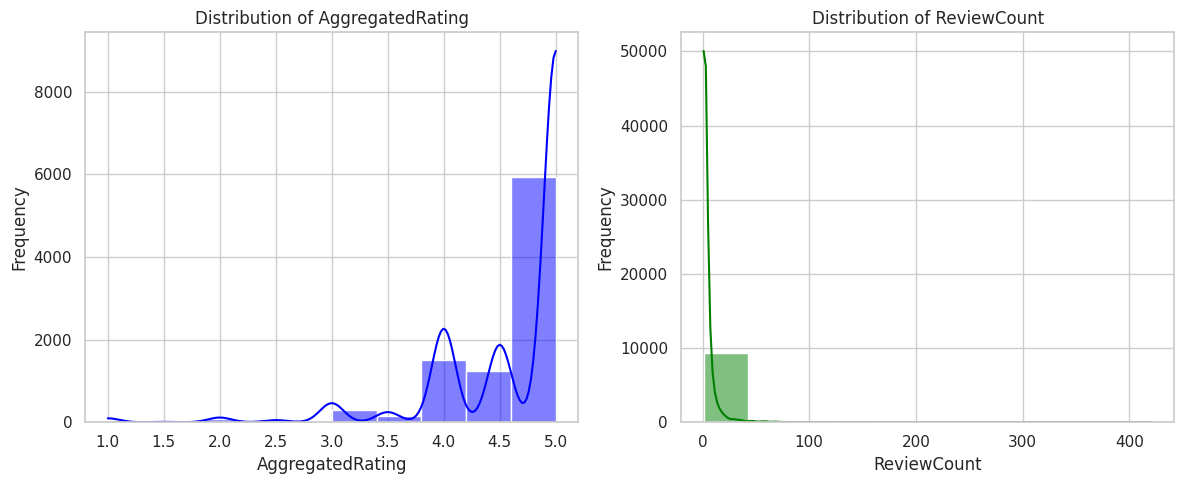

In [26]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(vegan_recipes['AggregatedRating'], bins=10, kde=True, color='blue')
plt.title('Distribution of AggregatedRating')
plt.xlabel('AggregatedRating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(vegan_recipes['ReviewCount'], bins=10, kde=True, color='green')
plt.title('Distribution of ReviewCount')
plt.xlabel('ReviewCount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
def nan_imputation(df, cols):
    for col in cols:
        nans = df[col].isna()
        df[col].fillna(0, inplace=True)

    return df
    
cols_to_impute = ["AggregatedRating", "ReviewCount"]
vegan_recipes = nan_imputation(vegan_recipes, cols_to_impute)
vegan_recipes[["AggregatedRating", "ReviewCount"]].isna().sum()

AggregatedRating    0
ReviewCount         0
dtype: int64

In [28]:
vegan_recipes.head()

,RecipeId,Name,AuthorId,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,RecipeTimeCategory
4,42,Cabbage Soup,1538,30,20,50,Make and share this Cabbage Soup recipe from F...,Vegetable,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,...",Medium
50,90,Almond Paste,1537,10080,15,10095,Make and share this Almond Paste recipe from F...,Dessert,"[Fruit, Nuts, Lactose Free, Vegan, Low Cholest...","[1, 3, 1, 2]","[fresh lemon juice, water, sugar]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,[Force blanched almonds through fine blade of ...,Very Long
88,133,Blueberry Pancake Syrup,1571,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"[Breakfast, Dessert, Berries, Fruit, Vegan, Fr...","[4, 3, 2, 3, NA]","[blueberries, water, lemons, rind of, sugar, l...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,[Pour the blueberries into a saucepan and crus...,Long
135,182,Low-Fat Apple &amp; Apricot,1533,20,20,40,Make and share this Low-Fat Apple &amp; Aprico...,Dessert,"[Apple, Fruit, Vegan, Free Of..., < 30 Mins, E...","[20, 12, 1/2, 2, 1, 1, 1, 1, NA]","[raisins, dried currant, lemon, rind of, cinna...",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,[Mix all ingredients thoroughly in a 3-quart p...,Medium
194,248,Mustard Dill Sauce I,1554,30,30,60,Make and share this Mustard Dill Sauce I recip...,Low Protein,"""< 30 Mins""","[1/2, 6, 1/4, 2, 1/2, 6]","[spicy brown mustard, sugar, distilled white v...",0.0,0.0,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,"[Whisk first 4 ingredients in bowl., Gradually...",Medium


### Cleaning textual data

Some of our categorical features are lists, and we want to convert them into strings before we proceed.

In [29]:
list_cols = ['Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeInstructions']

for col in list_cols:
    vegan_recipes[col] = vegan_recipes[col].apply(
        lambda x: [str(item).strip("'") if pd.notna(item) else item for item in x] if isinstance(x, list) else x
    )

In [30]:
list_cols = ['Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeInstructions']

for col in list_cols:
    if col == 'RecipeInstructions':
        vegan_recipes[col] = vegan_recipes[col].apply(
            lambda x: ' '.join([str(item) if pd.notna(item) else 'NaN' for item in x])
            if isinstance(x, list) else x
        )
    else:
        vegan_recipes[col] = vegan_recipes[col].apply(
            lambda x: ', '.join([str(item) if pd.notna(item) else 'NaN' for item in x])
            if isinstance(x, list) else x
        )

vegan_recipes[list_cols].head()

,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,RecipeInstructions
4,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","46, 4, 1, 2, 1","plain tomato juice, cabbage, onion, carrots, c...",Mix everything together and bring to a boil. R...
50,"Fruit, Nuts, Lactose Free, Vegan, Low Choleste...","1, 3, 1, 2","fresh lemon juice, water, sugar",Force blanched almonds through fine blade of f...
88,"Breakfast, Dessert, Berries, Fruit, Vegan, Fre...","4, 3, 2, 3, NA","blueberries, water, lemons, rind of, sugar, le...",Pour the blueberries into a saucepan and crush...
135,"Apple, Fruit, Vegan, Free Of..., < 30 Mins, Easy","20, 12, 1/2, 2, 1, 1, 1, 1, NA","raisins, dried currant, lemon, rind of, cinnam...",Mix all ingredients thoroughly in a 3-quart po...
194,"""< 30 Mins""","1/2, 6, 1/4, 2, 1/2, 6","spicy brown mustard, sugar, distilled white vi...",Whisk first 4 ingredients in bowl. Gradually w...


During data exploration, we noticed that some values include HTML elements that we want to get rid of.

In [31]:
vegan_recipes[
    vegan_recipes[['Name', 'Description', 'RecipeInstructions']].apply(
        lambda col: col.str.contains(r'http[s]?://\S+|www\.\S+|[|%$@#^**]|\.com|www\.[^\s]*\.com|\r|\n', regex=True, na=False)
    ).any(axis=1) 
].shape

(8747, 25)

We do the same for reviews that will be used as metadata.

In [32]:
vegan_recipes[['Name', 'Description', 'RecipeInstructions']] = vegan_recipes[
    ['Name', 'Description', 'RecipeInstructions']
].applymap(
    lambda x: re.sub(r'http[s]?://\S+|www\.\S+|[|%$@#^**]|\.com|www\.[^\s]*\.com|\r|\n', '', html.unescape(x)) 
              if isinstance(x, str) else x
)

# Sanity check

vegan_recipes[
    vegan_recipes[['Name', 'Description', 'RecipeInstructions']].apply(
        lambda col: col.str.contains(r'http[s]?://\S+|www\.\S+|[|%$@#^**]|\.com|www\.[^\s]*\.com|\r|\n', regex=True, na=False)
    ).any(axis=1) 
]

,RecipeId,Name,AuthorId,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,RecipeTimeCategory


In [33]:
vegan_recipes[vegan_recipes['Description'].str.startswith('Make and share', na=False)].shape

(5736, 25)

In [34]:
vegan_recipes['Description'] = vegan_recipes['Description'].apply(
    lambda x: 'Description not provided. Please generate a description.' if isinstance(x, str) and x.startswith('Make and share') else x
)

In [35]:
reviews_df[
    reviews_df['Review'].astype(str).str.contains(r'http[s]?://\S+|www\.\S+|[|%$@#^**]|\.com|www\.[^\s]*\.com|\r|\n', regex=True, na=False)
].shape

(215135, 8)

In [37]:
reviews_df['Review'] = reviews_df['Review'].apply(
    lambda x: re.sub(r'http[s]?://\S+|www\.\S+|[|%$@#^*]+|\.com|www\.[^\s]*\.com|\r|\n|&[a-z]+;', '', html.unescape(x)) if isinstance(x, str) else x
)

# Sanity check
reviews_df['Review'].apply(
    lambda x: bool(re.search(r'http[s]?://\S+|www\.\S+|[|%$@#^*]+|\.com|www\.[^\s]*\.com|\r|\n|&[a-z]+;', str(x))) 
).sum()

0

In [38]:
reviews_df = reviews_df.groupby('RecipeId', as_index=False).agg({
    'Review': lambda reviews: '; '.join(reviews.astype(str))},
abs)

reviews_df.head()

,RecipeId,Review
0,38,"Yummy, yummy, yummy! I am a big fan of fruit a..."
1,39,I have an Indian friend who made this dish for...
2,40,My favourite lemonade recipe is essentially th...
3,41,I thought this was very GOOD! ANYONE who is af...
4,42,This is a very good soup. We served ours warm...


## Preparing Data for Embedding

In [39]:
selected_cols = vegan_recipes.iloc[:, [1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]

def format_column_name(col):
    return re.sub(r'([a-z0-9])([A-Z])', r'\1 \2', col)

vegan_recipes["merged_text"] = selected_cols.apply(
    lambda row: "; ".join(
        [f"{format_column_name(col)}: {', '.join(row[col]) if isinstance(row[col], list) else row[col]}"
         for col in selected_cols.columns]
    ), axis=1
)

vegan_recipes['merged_text'].head()

4      Name: Cabbage Soup; Cooking Time Minutes: 30; ...
50     Name: Almond Paste; Cooking Time Minutes: 1008...
88     Name: Blueberry Pancake Syrup; Cooking Time Mi...
135    Name: Low-Fat Apple & Apricot; Cooking Time Mi...
194    Name: Mustard Dill Sauce I; Cooking Time Minut...
Name: merged_text, dtype: object

In [40]:
texts = vegan_recipes["merged_text"].to_list()
texts

['Name: Cabbage Soup; Cooking Time Minutes: 30; Preparation Time Minutes: 20; Total Recipe Minutes: 50; Description: Description not provided. Please generate a description.; Recipe Category: Vegetable; Keywords: Low Protein, Vegan, Low Cholesterol, Healthy, Winter, < 60 Mins, Easy; Recipe Ingredient Quantities: 46, 4, 1, 2, 1; Recipe Ingredient Parts: plain tomato juice, cabbage, onion, carrots, celery; Calories: 103.6; Fat Content: 0.4; Saturated Fat Content: 0.1; Cholesterol Content: 0.0; Sodium Content: 959.3; Carbohydrate Content: 25.1; Fiber Content: 4.8; Sugar Content: 17.7; Protein Content: 4.3; Recipe Servings: 4.0; Recipe Instructions: Mix everything together and bring to a boil. Reduce heat and simmer for 30 minutes (longer if you prefer your veggies to be soft). Refrigerate until cool. Serve chilled with sour cream.; Recipe Time Category: Medium',
 'Name: Almond Paste; Cooking Time Minutes: 10080; Preparation Time Minutes: 15; Total Recipe Minutes: 10095; Description: Descr

In [2]:
from IPython.display import clear_output
clear_output(wait=True)

In [42]:
metadata = vegan_recipes.iloc[:,[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24]]
metadata.head()

,RecipeId,Name,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeTimeCategory
4,42,Cabbage Soup,30,20,50,Description not provided. Please generate a de...,Vegetable,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","46, 4, 1, 2, 1","plain tomato juice, cabbage, onion, carrots, c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,Medium
50,90,Almond Paste,10080,15,10095,Description not provided. Please generate a de...,Dessert,"Fruit, Nuts, Lactose Free, Vegan, Low Choleste...","1, 3, 1, 2","fresh lemon juice, water, sugar",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,Very Long
88,133,Blueberry Pancake Syrup,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"Breakfast, Dessert, Berries, Fruit, Vegan, Fre...","4, 3, 2, 3, NA","blueberries, water, lemons, rind of, sugar, le...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,Long
135,182,Low-Fat Apple & Apricot,20,20,40,Description not provided. Please generate a de...,Dessert,"Apple, Fruit, Vegan, Free Of..., < 30 Mins, Easy","20, 12, 1/2, 2, 1, 1, 1, 1, NA","raisins, dried currant, lemon, rind of, cinnam...",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,Medium
194,248,Mustard Dill Sauce I,30,30,60,Description not provided. Please generate a de...,Low Protein,"""< 30 Mins""","1/2, 6, 1/4, 2, 1/2, 6","spicy brown mustard, sugar, distilled white vi...",0.0,0.0,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,Medium


In [64]:
metadata_with_reviews = pd.merge(metadata, reviews_df[['RecipeId', 'Review']], on='RecipeId', how='left')
metadata_with_reviews.head()

,RecipeId,Name,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeTimeCategory,Review
0,42,Cabbage Soup,30,20,50,Description not provided. Please generate a de...,Vegetable,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","46, 4, 1, 2, 1","plain tomato juice, cabbage, onion, carrots, c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,Medium,This is a very good soup. We served ours warm...
1,90,Almond Paste,10080,15,10095,Description not provided. Please generate a de...,Dessert,"Fruit, Nuts, Lactose Free, Vegan, Low Choleste...","1, 3, 1, 2","fresh lemon juice, water, sugar",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,Very Long,I liked this recipe very much. I would recomm...
2,133,Blueberry Pancake Syrup,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"Breakfast, Dessert, Berries, Fruit, Vegan, Fre...","4, 3, 2, 3, NA","blueberries, water, lemons, rind of, sugar, le...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,Long,this was wonderful - canned it in pints for fu...
3,182,Low-Fat Apple & Apricot,20,20,40,Description not provided. Please generate a de...,Dessert,"Apple, Fruit, Vegan, Free Of..., < 30 Mins, Easy","20, 12, 1/2, 2, 1, 1, 1, 1, NA","raisins, dried currant, lemon, rind of, cinnam...",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,Medium,NaN
4,248,Mustard Dill Sauce I,30,30,60,Description not provided. Please generate a de...,Low Protein,"""< 30 Mins""","1/2, 6, 1/4, 2, 1/2, 6","spicy brown mustard, sugar, distilled white vi...",0.0,0.0,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,Medium,NaN


In [66]:
metadata_with_reviews['Review'].isna().sum()

0

In [65]:
metadata_with_reviews['Review'].fillna('No reviews', inplace=True)

In [67]:
metadata_with_reviews.head()

,RecipeId,Name,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeTimeCategory,Review
0,42,Cabbage Soup,30,20,50,Description not provided. Please generate a de...,Vegetable,"Low Protein, Vegan, Low Cholesterol, Healthy, ...","46, 4, 1, 2, 1","plain tomato juice, cabbage, onion, carrots, c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,Medium,This is a very good soup. We served ours warm...
1,90,Almond Paste,10080,15,10095,Description not provided. Please generate a de...,Dessert,"Fruit, Nuts, Lactose Free, Vegan, Low Choleste...","1, 3, 1, 2","fresh lemon juice, water, sugar",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,Very Long,I liked this recipe very much. I would recomm...
2,133,Blueberry Pancake Syrup,36,50,86,"I've made this blueberry syrup several times, ...",Sauces,"Breakfast, Dessert, Berries, Fruit, Vegan, Fre...","4, 3, 2, 3, NA","blueberries, water, lemons, rind of, sugar, le...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,Long,this was wonderful - canned it in pints for fu...
3,182,Low-Fat Apple & Apricot,20,20,40,Description not provided. Please generate a de...,Dessert,"Apple, Fruit, Vegan, Free Of..., < 30 Mins, Easy","20, 12, 1/2, 2, 1, 1, 1, 1, NA","raisins, dried currant, lemon, rind of, cinnam...",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,Medium,No reviews
4,248,Mustard Dill Sauce I,30,30,60,Description not provided. Please generate a de...,Low Protein,"""< 30 Mins""","1/2, 6, 1/4, 2, 1/2, 6","spicy brown mustard, sugar, distilled white vi...",0.0,0.0,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,NaN,Medium,No reviews


# Main Dataset Embeddings

In [45]:
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
gc.collect() 
torch.cuda.empty_cache()

In [54]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenized_texts = tokenizer(texts, padding=False, truncation=False, return_tensors = None)

lengths = [len(tokens) for tokens in tokenized_texts['input_ids']]

describe(lengths)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors


DescribeResult(nobs=17598, minmax=(165, 2063), mean=359.77236049551084, variance=13771.943972048926, skewness=2.1692397175070317, kurtosis=12.317848416833488)

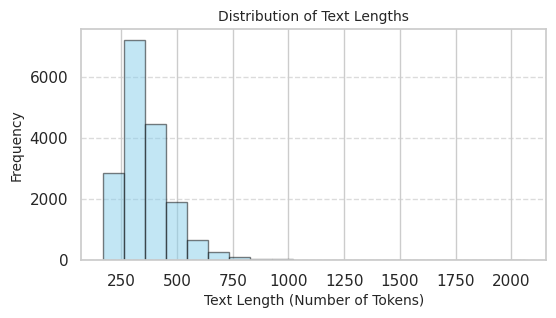

In [55]:
plt.figure(figsize=(6, 3))
plt.hist(lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.5) 
plt.title("Distribution of Text Lengths", fontsize=10)
plt.xlabel("Text Length (Number of Tokens)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [46]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

batch_size = 32 

embeddings_list = []

for i in range(0, len(texts), batch_size):
    print(f"Processing batch {i // batch_size + 1} of {len(texts) // batch_size + 1}")
    batch_texts = texts[i:i + batch_size]
    
    encoded_input = tokenizer(
        batch_texts,
        padding=True,            
        truncation=True,         
        max_length=512,          
        return_tensors='pt'     
    )
    

    with torch.no_grad():
        output = model(**encoded_input)
    
    last_hidden_states = output.last_hidden_state
    
    attention_mask = encoded_input["attention_mask"]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
    mean_pooled_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )
    
    embeddings_list.append(mean_pooled_embeddings)

all_embeddings = torch.cat(embeddings_list, dim=0)

print(all_embeddings.shape)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Processing batch 1 of 550
Processing batch 2 of 550
Processing batch 3 of 550
Processing batch 4 of 550
Processing batch 5 of 550
Processing batch 550 of 550
torch.Size([17598, 768])


In [3]:
clear_output(wait=True)

In [47]:
from sklearn.preprocessing import normalize

embed_np = all_embeddings.numpy()
normalized_embeds = normalize(embed_np, norm='l2')

In [48]:
recipe_ids = vegan_recipes['RecipeId']
embed_texts_for_database = pd.DataFrame(
    {
        "Id": recipe_ids,  
        "VectorData": list(normalized_embeds)  
    }
)

embed_texts_for_database.head()

,Id,VectorData
4,42,"[-0.063417144, -0.0011946427, 0.036288198, 0.0..."
50,90,"[-0.059560403, 0.002911371, 0.038085777, 0.006..."
88,133,"[-0.04840912, 0.0020992083, 0.03166137, 0.0101..."
135,182,"[-0.060834955, 0.0035884902, 0.035789214, 0.00..."
194,248,"[-0.06397649, 0.0010772683, 0.03641214, -0.001..."


In [49]:
import json

data_save = [
    {
        "RecipeId": row['Id'],  
        "VectorData": row['VectorData'].tolist()}
    for _, row in embed_texts_for_database.iterrows()  
]

with open('recipes_data.json', 'w') as f:
    json.dump(data_save, f, indent=4)

print("Data saved to recipes_data.json")

Data saved to recipes_data.json


In [50]:
embed_texts_for_database['VectorData'] = embed_texts_for_database['VectorData'].apply(lambda x: ', '.join(map(str, x)))

embed_texts_for_database[['Id', 'VectorData']].to_csv('recipes_vectors.csv', index=False)

print("Vector data saved to recipes_vectors.csv")

Vector data saved to recipes_vectors.csv


# Metadata Embeddings

In [17]:
metadata_cols_to_embed = ['Name', 'Description', 'RecipeCategory', 'RecipeIngredientParts', 'Keywords', 'Review']

# for col in metadata_cols_to_embed:
#     metadata_with_reviews[col] = metadata_with_reviews[col].apply(lambda x: [x] if not isinstance(x, list) else x)

In [54]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenized_texts = tokenizer(metadata_with_reviews['Review'].astype(str).tolist(), padding=False, truncation=False, return_tensors = None)

lengths = [len(tokens) for tokens in tokenized_texts['input_ids']]

describe(lengths)

Token indices sequence length is longer than the specified maximum sequence length for this model (2570 > 512). Running this sequence through the model will result in indexing errors


DescribeResult(nobs=17598, minmax=(5, 28640), mean=181.58506648482782, variance=390943.6577914117, skewness=17.560249892109507, kurtosis=517.9911733077157)

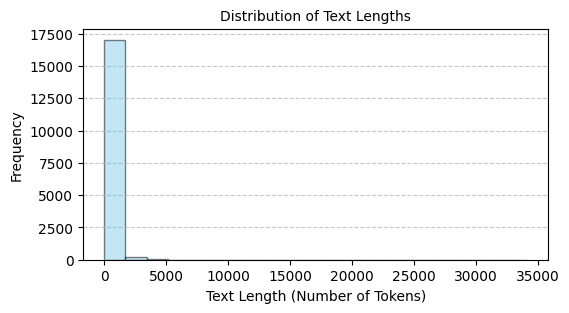

In [58]:
plt.figure(figsize=(6, 3))
plt.hist(lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.5) 
plt.title("Distribution of Text Lengths", fontsize=10)
plt.xlabel("Text Length (Number of Tokens)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [43]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [69]:
def embed_metadata(text_data):
    inputs = tokenizer(text_data, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    embedding = outputs.last_hidden_state.mean(dim=1)

    embedding_list = embedding.squeeze().tolist()

    return embedding_list

In [71]:
for col in metadata_cols_to_embed:
    print(f"Processing column: {col}")  
    metadata_with_reviews[f"{col}_embedding"] = metadata_with_reviews[col].apply(embed_metadata)

Processing column: Name
Processing column: Description
Processing column: RecipeCategory
Processing column: RecipeIngredientParts
Processing column: Keywords
Processing column: Review


In [74]:
metadata_with_reviews.head()

,RecipeId,Name,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeTimeCategory,Review,Name_embedding,Description_embedding,RecipeCategory_embedding,RecipeIngredientParts_embedding,Keywords_embedding,Review_embedding,Name_embedding_normalized,Description_embedding_normalized,RecipeCategory_embedding_normalized,RecipeIngredientParts_embedding_normalized,Keywords_embedding_normalized,Review_embedding_normalized
0,42,[Cabbage Soup],30,20,50,[Description not provided. Please generate a d...,[Vegetable],"[Low Protein, Vegan, Low Cholesterol, Healthy,...","46, 4, 1, 2, 1","[plain tomato juice, cabbage, onion, carrots, ...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,Medium,[This is a very good soup. We served ours war...,"[0.11147043853998184, 0.01104094460606575, -0....","[-0.056647371500730515, -0.14212821424007416, ...","[0.2583865225315094, 0.0775633379817009, -0.24...","[-0.06790915876626968, 0.1569654941558838, 0.1...","[-0.3187265396118164, 0.015484263189136982, 0....","[-0.11408206820487976, 0.049858368933200836, 0...","[0.014551365020895334, 0.0014412862929638775, ...","[-0.005302073340523476, -0.013302898187408188,...","[0.03308006820602776, 0.009930086467296135, -0...","[-0.00730635277329166, 0.01688793226675299, 0....","[-0.04041561865382728, 0.0019634576930739364, ...","[-0.015295426205164102, 0.0066847052716300604,..."
1,90,[Almond Paste],10080,15,10095,[Description not provided. Please generate a d...,[Dessert],"[Fruit, Nuts, Lactose Free, Vegan, Low Cholest...","1, 3, 1, 2","[fresh lemon juice, water, sugar]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,NaN,Very Long,[I liked this recipe very much. I would recom...,"[0.14290957152843475, 0.08623308688402176, -0....","[-0.056647371500730515, -0.14212821424007416, ...","[0.145246684551239, 0.09349077194929123, -0.05...","[0.11045094579458237, 0.1101234033703804, 0.02...","[-0.18110691010951996, 0.018967995420098305, 0...","[-0.05769820138812065, 0.07190047949552536, 0....","[0.018272325558733246, 0.011025706820245153, -...","[-0.005302073340523476, -0.013302898187408188,...","[0.01873073444646906, 0.012056391014968845, -0...","[0.013385857787410277, 0.01334616200863564, 0....","[-0.023087104573134176, 0.0024179977094287604,...","[-0.007852891679524536, 0.00978586270629374, 0..."
2,133,[Blueberry Pancake Syrup],36,50,86,"[I've made this blueberry syrup several times,...",[Sauces],"[Breakfast, Dessert, Berries, Fruit, Vegan, Fr...","4, 3, 2, 3, NA","[blueberries, water, lemons, rind of, sugar, l...",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,NaN,Long,[this was wonderful - canned it in pints for f...,"[-0.07431793212890625, -0.0765952542424202, -0...","[0.15627917647361755, 0.1361067295074463, 0.07...","[0.26149556040763855, 0.07175633311271667, -0....","[-0.06912896037101746, 0.13105681538581848, 0....","[-0.06459131836891174, 0.0255263801664114, 0.4...","[-0.02732006087899208, 0.07763074338436127, 0....","[-0.009007529093189184, -0.009283546530763463,...","[0.019307196807574346, 0.016815032384555558, 0...","[0.03146028024559924, 0.008632935662859905, -0...","[-0.008343223306984799, 0.01581734009592587, 0...","[-0.008413793421250924, 0.0033251169806726593,...","[-0.003633928759029627, 0.010325913701978802, ..."
3,182,[Low-Fat Apple & Apricot],20,20,40,[Description not provided. Please generate a d...,[Dessert],"[Apple, Fruit, Vegan, Free Of..., < 30 Mins, E...","20, 12, 1/2, 2, 1, 1, 1, 1, NA","[raisins, dried currant, lemon, rind of, cinna...",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,Medium,[No reviews],"[-0.07919036597013474, 0.10127286612987518, -0...","[-0.056647371500730515, -0.14212821424007416, ...","[0.145246684551239, 0.09349077194929123, -0.05..."

In [18]:
embedding_columns = [
    'Name_embedding', 'Description_embedding', 
    'RecipeCategory_embedding', 'RecipeIngredientParts_embedding', 
    'Keywords_embedding', 'Review_embedding'
]

# for col in embedding_columns:

#     embeddings = metadata_with_reviews[col].apply(lambda x: np.array(x))  
#     embed_np = np.vstack(embeddings)
#     normalized_embeds = normalize(embed_np, norm='l2')
#     metadata_with_reviews[f"{col}_normalized"] = list(normalized_embeds)

In [75]:
metadata_with_reviews.to_csv('metadata_embed_all_cols.csv', index=False)

print("Vector data saved to metadata_embed_all_cols.csv")

Vector data saved to metadata_embed_all_cols.csv


In [2]:
file_path = '/kaggle/input/metadata'
pd.set_option('display.max_columns', None)
metadata_with_reviews = pd.read_csv(file_path + '/metadata_embed_all_cols.csv')

In [19]:
metadata_with_reviews = metadata_with_reviews.drop(columns=metadata_cols_to_embed + embedding_columns)

In [5]:
def convert_to_list(value):
    if isinstance(value, str):
        return [int(x) if x.isdigit() else None for x in value.split(", ")]
    return value 

metadata_with_reviews["RecipeIngredientQuantities"] = metadata_with_reviews["RecipeIngredientQuantities"].apply(convert_to_list)

In [6]:
metadata_with_reviews = metadata_with_reviews.replace({np.nan: None})

In [7]:
def convert_embedding_string(embedding_string):
    # Remove the square brackets
    embedding_string = embedding_string.strip('[]')
    
    # Split the string by spaces to get each individual element
    embedding_list = embedding_string.split()
    
    # Convert each element into a float and return it as a list
    embedding_floats = [float(x) for x in embedding_list]
    return embedding_floats

embedding_columns_norm = [
    "Name_embedding_normalized", "Description_embedding_normalized",
    "RecipeCategory_embedding_normalized", "RecipeIngredientParts_embedding_normalized",
    "Keywords_embedding_normalized", "Review_embedding_normalized"
]

for col in embedding_columns_norm:
    metadata_with_reviews[col] = metadata_with_reviews[col].apply(convert_embedding_string)

In [20]:
metadata_with_reviews.head()

,RecipeId,CookingTimeMinutes,PreparationTimeMinutes,TotalRecipeMinutes,RecipeIngredientQuantities,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeTimeCategory,Name_embedding_normalized,Description_embedding_normalized,RecipeCategory_embedding_normalized,RecipeIngredientParts_embedding_normalized,Keywords_embedding_normalized,Review_embedding_normalized
0,42,30,20,50,"[46, 4, 1, 2, 1]",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,Medium,"[0.014551365, 0.00144128629, -0.0450013956, 0....","[-0.00530207334, -0.0133028982, -0.00344163006...","[0.0330800682, 0.00993008647, -0.0316792038, 0...","[-0.00730635277, 0.0168879323, 0.0129905029, 0...","[-0.0404156187, 0.00196345769, 0.0309701885, 0...","[-0.0152954262, 0.00668470527, 0.0161962478, 0..."
1,90,10080,15,10095,"[1, 3, 1, 2]",4.0,2.0,2123.5,119.8,9.0,0.0,49.1,244.0,22.6,210.7,48.9,None,Very Long,"[0.01827233, 0.01102571, -0.03225231, 0.016608...","[-0.00530207334, -0.0133028982, -0.00344163006...","[0.0187307344, 0.012056391, -0.00672038077, 0....","[0.0133858578, 0.013346162, 0.0026506235, 0.04...","[-0.0230871046, 0.00241799771, 0.0350617778, 0...","[-0.00785289168, 0.00978586271, 0.0185655671, ..."
2,133,36,50,86,"[4, 3, 2, 3, None]",5.0,4.0,1329.7,1.0,0.1,0.0,16.6,342.8,7.1,328.9,2.2,None,Long,"[-0.00900752909, -0.00928354653, -0.0068938623...","[0.0193071968, 0.0168150324, 0.00888831661, 0....","[0.0314602802, 0.00863293566, -0.0245967044, 0...","[-0.00834322331, 0.0158173401, 0.0182966437, 0...","[-0.00841379342, 0.00332511698, 0.0533059549, ...","[-0.00363392876, 0.0103259137, 0.0361631219, 0..."
3,182,20,20,40,"[20, 12, None, 2, 1, 1, 1, 1, None]",0.0,0.0,164.5,0.3,0.0,0.0,7.9,42.4,2.5,35.5,1.4,4.0,Medium,"[-0.00906305113, 0.0115903134, -0.00262362654,...","[-0.00530207334, -0.0133028982, -0.00344163006...","[0.0187307344, 0.012056391, -0.00672038077, 0....","[0.00349121076, 0.0117972546, 0.0296686234, 0....","[-0.00733207045, -0.00720671798, 0.0343952905,...","[0.0166545369, 0.0012823328, -0.00742303272, 0..."
4,248,30,30,60,"[None, 6, None, 2, None, 6]",0.0,0.0,921.1,76.5,9.6,0.0,935.7,58.6,3.4,53.0,4.5,None,Medium,"[0.0209698538, 0.00076768779, 0.00148870368, 0...","[-0.00530207334, -0.0133028982, -0.00344163006...","[-0.0184525837, 0.000214162646, -0.0242528206,...","[-0.0150688413, 0.0101713991, -0.00287114718, ...","[0.0138302438, -0.0302947164, 0.052978378, -0....","[0.0166545369, 0.0012823328, -0.00742303272, 0..."


In [25]:
with open('metadata_with_reviews.json', 'r') as file:
    # Read lines to see if they contain valid JSON objects
    lines = file.readlines()

# Check if there are extra lines or malformed entries
print(lines[:1]) 

['{"RecipeId":42,"CookingTimeMinutes":30,"PreparationTimeMinutes":20,"TotalRecipeMinutes":50,"RecipeIngredientQuantities":[46,4,1,2,1],"AggregatedRating":4.5,"ReviewCount":11.0,"Calories":103.6,"FatContent":0.4,"SaturatedFatContent":0.1,"CholesterolContent":0.0,"SodiumContent":959.3,"CarbohydrateContent":25.1,"FiberContent":4.8,"SugarContent":17.7,"ProteinContent":4.3,"RecipeServings":4.0,"RecipeTimeCategory":"Medium","Name_embedding_normalized":[0.014551365,0.0014412863,-0.0450013956,0.0109033312,0.0138146431,-0.0005652185,0.0118900793,0.0462791427,-0.0120191948,-0.0157450337,-0.0069310462,-0.0296950977,-0.0020471425,0.0098968665,-0.0393789211,0.0103750111,0.0226781175,0.0064112952,-0.0170044512,0.0173518171,0.0194373121,-0.0519738464,-0.014241095,0.0155050603,0.0253909102,-0.00799178,-0.0213970986,0.0107321682,-0.0000924485...

In [4]:
clear_output(wait=True)

In [22]:
import json

metadata_with_reviews.to_json("metadata_with_reviews.json", orient="records", lines=True)


In [26]:
metadata_with_reviews.to_csv("metadata_with_reviews.csv", index=False)